<img src='https://gitlab.ifremer.fr/odatis/vre/tools/frameworks/-/raw/main/img/standard_banner.png' align='right' width='100%' style="margin-bottom: 1rem;"/>

<hr>

# 1. Accessing BGC-Argo data

<hr>

<div class="alert alert-block alert-success">

<h3>Learning outcomes</h3> 

At the end of this notebook you will know;
* How to <font color="#2367a2">**access**</font> BGC-Argo index.
* How to calculate some <font color="#2367a2">**statistics**</font> on BGC-Argo fleet data
</div>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="./README.md" target="_blank">README</a>**.

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

## 1.1 Load BGC-Argo Index

All Argo profiles are accessible from an index file, which lists the essential information about each profile. (e.g. id, longitude, latitude, date, etc.). This file can be accessed locally on Datarmor, or via FTP or HTTP. 

*Choose the access method that suits you best (by default, local access).*

In [2]:
# Different ways of accessing the BGC-Argo index file
access = {
    'ftp': "ftp://ftp.ifremer.fr/ifremer/argo/argo_bio-profile_index.txt",
    'http': "https://data-argo.ifremer.fr/argo_bio-profile_index.txt",
    'local': "/home/ref-argo/gdac/argo_bio-profile_index.txt",
}

# Choose the access method that suits you best
path = access['local']

The 1st step is to load the index file. We also take this opportunity to pre-format the file, by performing the following operations: 
* Formatting the date in `datetime64` format
* Creation of a column for the float identifier
* Formatting the parameters as a list

In [3]:
# Open and format the BGC-ARgo index file
df = pd.read_csv(path, sep=",", header=8)
df['date']= pd.to_datetime(df['date'], format='%Y%m%d%H%M%S')
df['id'] = df['file'].str.split('/').str[1]
df["parameters"] = df["parameters"].str.split()
df.head()

,file,date,latitude,longitude,ocean,profiler_type,institution,parameters,parameter_data_mode,date_update,id
0,aoml/1900722/profiles/BD1900722_001.nc,2006-10-22 02:16:24,-40.316,73.389,I,846,AO,"[PRES, TEMP_DOXY, BPHASE_DOXY, DOXY]",RRRD,20200312153230,1900722
1,aoml/1900722/profiles/BD1900722_002.nc,2006-11-01 06:44:23,-40.390,73.528,I,846,AO,"[PRES, TEMP_DOXY, BPHASE_DOXY, DOXY]",RRRD,20200312153230,1900722
2,aoml/1900722/profiles/BD1900722_003.nc,2006-11-11 10:12:22,-40.455,73.335,I,846,AO,"[PRES, TEMP_DOXY, BPHASE_DOXY, DOXY]",RRRD,20200312153230,1900722
3,aoml/1900722/profiles/BD1900722_004.nc,2006-11-21 07:50:21,-40.134,73.080,I,846,AO,"[PRES, TEMP_DOXY, BPHASE_DOXY, DOXY]",RRRD,20200312153230,1900722
4,aoml/1900722/profiles/BD1900722_005.nc,2006-12-01 18:33:00,-39.641,73.158,I,846,AO,"[PRES, TEMP_DOXY, BPHASE_DOXY, DOXY]",RRRD,20200312153230,1900722


The result is a table listing all the existing BGC-Argo profiles, known as an index. For each profile, we find the essential information concerning it:
* **id:** the ARGO float identifier
* **longitude / latitude:** the geographical coordinates where the profile was acquired
* **date:** the date on which the profile was acquired
* **parameters:** the list of parameters available for this profile
* **file:** the path to the profile data
  
Now that we have access to the index file, let's calculate some statistics to get a better idea of the size and content of the BGC-Argo fleet.

## 1.2 Some statistics on profiles

####  Number of floats and profiles

To get an idea of what we're talking about when we talk about the BGC-Argo fleet, we'll start by looking at the number of floats and the number of profiles.

In [4]:
# Groupby by float
floats = df.groupby("id")["date"].agg(min_date="min", max_date="max", count="size").reset_index().sort_values(by="count", ascending=False)

In [5]:
print(
    f"Number of floats: {len(floats)}",
    f"\nNumber of profiles: {sum(floats['count'])}"
)

Number of floats: 2521 
Number of profiles: 353205


Obviously the distribution of profiles is not equitable between all the floats, so let's take a look at the 10 floats that have acquired the most profiles. 

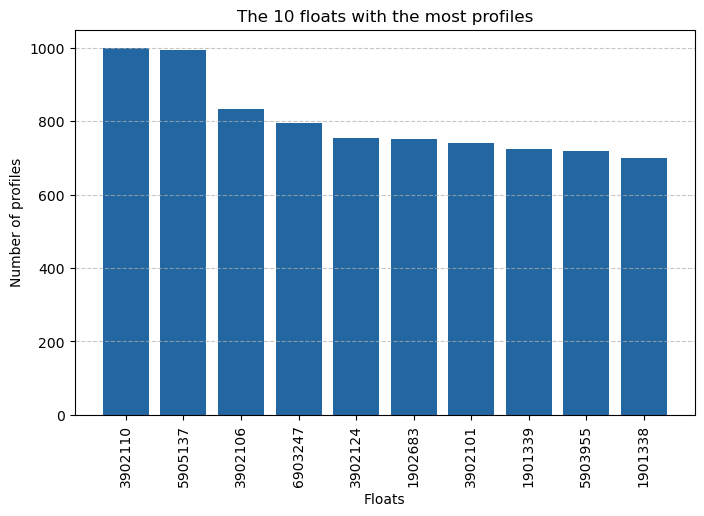

In [6]:
flts = floats.head(10)
plt.figure(figsize=(8, 5))
plt.bar(flts["id"], flts["count"], color="#2367a2")
plt.xlabel("Floats")
plt.ylabel("Number of profiles")
plt.title("The 10 floats with the most profiles")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### Number of parameters

Each float has a number of sensors, so not all profiles contain the same parameters. It is interesting to see the number of parameters that exist and which are the most represented. 

In [7]:
# Groupby by parameters
params = df.explode("parameters", ignore_index=True).groupby("parameters").size().reset_index(name="count").sort_values(by="count", ascending=False)

In [8]:
print(f"Number of parameters: {len(params)}")

Number of parameters: 125


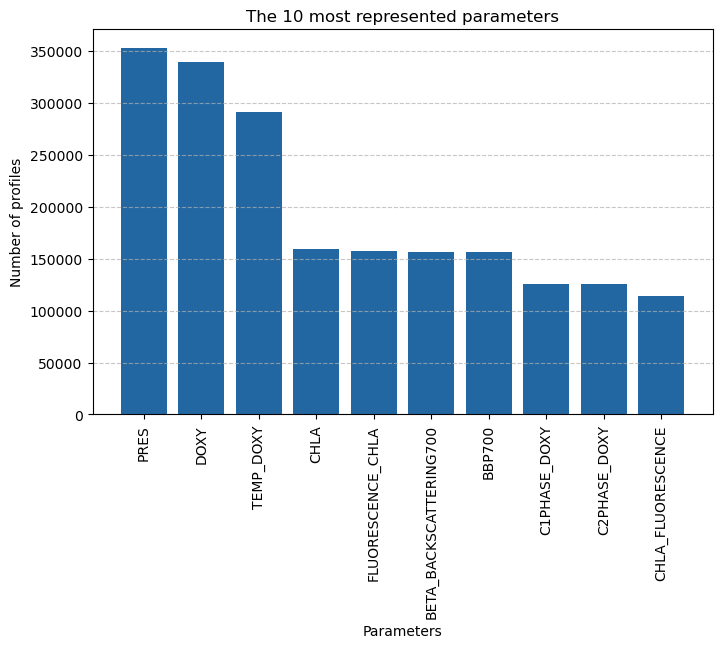

In [9]:
prms = params.head(10)
plt.figure(figsize=(8, 5))
plt.bar(prms["parameters"], prms["count"], color="#2367a2")
plt.xlabel("Parameters")
plt.ylabel("Number of profiles")
plt.title("The 10 most represented parameters")
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## 1.3 Formatting the data for collocation

Now that we know a little more about the content of the BGC-Argo fleet, we are going to finalise the formatting of the data for the rest of our use case. 

To calibrate and qualify the BGC-Argo data, we're going to use the data from the `OCEANCOLOUR` satellite product. To do this, we'll need floats with a chlorophyll-a sensor (noted `CHLA`).

In [10]:
df = df[df['parameters'].apply(lambda x: 'CHLA' in x)]
df = df.dropna(subset=['longitude', 'latitude', 'id', 'date'])
dataset = xr.Dataset.from_dataframe(df)
dataset = dataset.rename({'index':'obs', 'longitude':'lon', 'latitude':'lat', 'date':'time'})
dataset

<xarray.Dataset> Size: 15MB
Dimensions:              (obs: 157359)
Coordinates:
  * obs                  (obs) int64 1MB 1956 1957 1958 ... 353202 353203 353204
Data variables:
    file                 (obs) object 1MB 'aoml/1902303/profiles/BD1902303_00...
    time                 (obs) datetime64[ns] 1MB 2021-05-06T02:03:16 ... 202...
    lat                  (obs) float64 1MB 49.24 49.1 48.91 ... 49.03 48.97
    lon                  (obs) float64 1MB -14.74 -14.62 ... -130.0 -130.1
    ocean                (obs) object 1MB 'A' 'A' 'A' 'A' ... 'P' 'P' 'P' 'P'
    profiler_type        (obs) int64 1MB 863 863 863 863 863 ... 834 834 834 834
    institution          (obs) object 1MB 'AO' 'AO' 'AO' 'AO' ... 'ME' 'ME' 'ME'
    parameters           (obs) object 1MB ['PRES', 'TEMP_DOXY', 'PHASE_DELAY_...
    parameter_data_mode  (obs) object 1MB 'RRRRDRAARARRRRRDRRD' ... 'RRRRRRRR...
    date_update          (obs) int64 1MB 20250625040143 ... 20250619123140
    id                   (obs) object 1MB '1902303' '1902303' ... '4902691'